# Degeneracy woes

One of the most fundamental stumbling blocks for newcomers into the field of eclipsing binary stars is the realization that a _good-looking_ fit is not necessarily _unique_ nor _correct_. In other words, a _right_ combination of the _wrong_ parameters can fool you into thinking that the model is correct. In this tutorial we will generate our own dataset (so that we know what the actual true answer is). First things first, though, the usual imports.

In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='WARNING')

Next up, we generate our model. Two main-sequence stars in a close orbit, no frills.

In [2]:
b = phoebe.default_binary()
b['requiv@primary'] = 1.35
b['requiv@secondary'] = 0.80
b['teff@primary'] = 6150
b['teff@secondary'] = 5680
b['q@orbit'] = 0.78
b['incl@orbit'] = 83.5

Let's generate a single lightcurve in Johnson V passband, and oversample it a little so that we gain full grasp of its topological beauty:

100%|██████████| 241/241 [00:06<00:00, 39.04it/s]


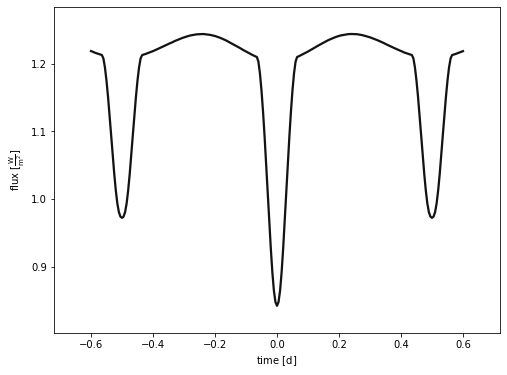

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [3]:
b.add_dataset('lc', times=phoebe.linspace(-0.6, 0.6, 241), passband='Johnson:V', dataset='ideal_lc', overwrite=True)
b.run_compute(irrad_method='none')
b.plot(show=True)

This is arguably quite a feature*ful* lightcurve, which makes us expect that parameters will be reasonably well constrained. We will use this lightcurve as a generative model for the data:

In [4]:
times = b['value@times@model@ideal_lc']
fluxes = b['value@fluxes@model@ideal_lc'] + np.random.normal(0, 0.01, size=241)
sigmas = np.ones_like(times)*0.01

Let's add another dataset (called `mock`) that will provide the data we just generated:

In [5]:
b.add_dataset('lc', passband='Johnson:V', times=times, fluxes=fluxes, sigmas=sigmas, dataset='mock')

<ParameterSet: 45 parameters | contexts: compute, constraint, figure, dataset>

We no longer need the original dataset so we will disable it:

In [6]:
b.disable_dataset('ideal_lc')

<ParameterSet: 19 parameters | components: secondary, binary, primary>

We now make sure that everything is up to snuff and looks good:

Fri, 20 May 2022 14:46 BUNDLE       WARNING overwriting model: latest
100%|██████████| 241/241 [00:06<00:00, 38.19it/s]


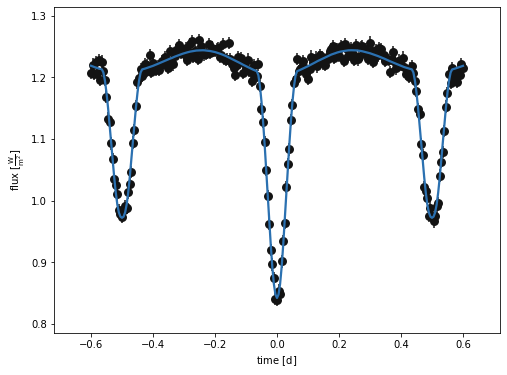

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [7]:
b.run_compute(irrad_method='none')
b.plot(show=True)

So far we did not modify any parameter values, so the chi2 value will be near-minimal (we say "near" because any stochastic non-gaussianity might affect the chi2 value slightly):

In [8]:
b.calculate_chi2()

205.2929564955067

This is the chi2 value that the minimizer should gravitate to. Typically, the Nelder & Mead optimizer is favored because it is globally convergent as it depends only on function evaluations, but this pro comes at a cost of prolonged computation time. Instead, we will use the _locally_ convergent differential corrections (DC) algorithm instead. Here's a quick 'n dirty implementation of it:

In [9]:
def run_dc(adjusts, steps, deriv_method='sym'):
    obs = b['value@fluxes@mock@dataset']
    sigs = b['value@sigmas@mock@dataset']
    fit_params = adjusts
    orig_values = [b[f'value@{param}'] for param in fit_params]

    A = np.empty(shape=(len(obs), len(fit_params)))
    V = np.diag(1/sigs)

    b.run_compute(irrad_method='none', model='baseline', overwrite=True, progressbar=False)
    xi = obs-b['value@fluxes@baseline@model']

    for k, param in enumerate(fit_params):
        # analytical derivatives:
        if 'pblum' in param:
            A[:,k] = 1
            continue
        # numerical derivatives:
        if deriv_method == 'asym':
            b[param] = orig_values[k] + steps[k]
            b.run_compute(irrad_method='none', model='upper', overwrite=True, progressbar=False)
        elif deriv_method == 'sym':
            b[param] = orig_values[k] + steps[k]/2
            b.run_compute(irrad_method='none', model='upper', overwrite=True, progressbar=False)
            b[param] = orig_values[k] - steps[k]/2
            b.run_compute(irrad_method='none', model='lower', overwrite=True, progressbar=False)
        else:
            raise ValueError(f"deriv_method='{deriv_method}' is not recognized ('sym' or 'asym' supported).")

        b[param] = orig_values[k]

        if deriv_method == 'asym':
            A[:,k] = (b['value@fluxes@upper']-b['value@fluxes@baseline@model'])/steps[k]
        else:
            A[:,k] = (b['value@fluxes@upper']-b['value@fluxes@lower'])/steps[k]

    return np.linalg.lstsq(V@A, V@xi, rcond=None)

def adopt_dc(params, corrections):
    for param, correction in zip(params, corrections):
        b[param] = b[f'value@{param}'] + correction

In a nutshell, DC minimizes the residuals between the data and the model by evaluating numerical derivatives of the residuals w.r.t. each adjusted parameter. By doing that, it finds the corrections for each adjusted parameter that reduce the overall residuals. In order for DC to work well, the starting point needs to be close to the optimum, steps for numerical derivation need to be chosen reasonably well, and data noise needs to be normally distributed, homoskedastic and uncorrelated. Even a casual reader will have noticed the use of "close" and "reasonably well" that are largely meaningless -- both depend on many aspects of data fitting: from dynamical space spun by the parameters to data noise and adjusted parameter correlations. Trial and error is the only fool-proof way of attributing the quantitative meaning to "close" and "reasonably well".

Now let's see how parameters react to being modified, and if we can trust DC to drive them back to their initial value. We start with displacing a single parameter (secondary star's effective temperature):

In [10]:
print(f"original T2: {b['value@teff@secondary']}")
b['teff@secondary'] = 5880
print(f"modified T2: {b['value@teff@secondary']}")
adjusts = ['teff@secondary']
steps = [50]
for iter in range(1, 4):
    corrections = run_dc(adjusts, steps, deriv_method='asym')
    adopt_dc(adjusts, corrections[0])
    print(f"adjusted T2: {b['value@teff@secondary']} (it {iter})")

original T2: 5680.0
modified T2: 5880.0
adjusted T2: 5691.440827805122 (it 1)
adjusted T2: 5679.078776911256 (it 2)
adjusted T2: 5678.744400112769 (it 3)


Next, let's try to vary more parameters than just the one we displaced; the obvious choices are passband luminosity (to account for flux scaling) and equivalent radii:

In [11]:
print(f"original T2: {b['value@teff@secondary']}")
b['teff@secondary'] = 5880
print(f"modified T2: {b['value@teff@secondary']}")
adjusts = ['teff@secondary', 'pblum@primary@mock', 'requiv@primary', 'requiv@secondary']
steps = [50, 0.01, 0.05, 0.05]
for iter in range(1, 4):
    corrections = run_dc(adjusts, steps, deriv_method='asym')
    adopt_dc(adjusts, corrections[0])
    print(f"adjusted T2: {b['value@teff@secondary']} (it {iter})")

original T2: 5678.744400112769
modified T2: 5880.0
adjusted T2: 5692.856208929303 (it 1)
adjusted T2: 5679.912368079984 (it 2)
adjusted T2: 5679.582402820114 (it 3)


So far this looks quite reasonable; now let's add the primary temperature to the mix, and increase the number of iterations. Let's also track the chi2 value for each iteration:

In [12]:
adjusts = ['teff@primary', 'teff@secondary', 'pblum@primary@mock']
steps = [50, 50, 0.05]

for i in range(10):
    corrections = run_dc(adjusts, steps, deriv_method='asym')
    print(f'iteration: {i+1:02d}, corrections: {corrections[0]}, chi2: {corrections[1][0]}')
    adopt_dc(adjusts, corrections[0])

iteration: 01, corrections: [-5.97661391e+02 -4.83520766e+02  3.02443863e-03], chi2: 203.0348627210778
iteration: 02, corrections: [-1.33287228e+01 -2.81551076e+01  4.35640484e-03], chi2: 202.3657083154521
iteration: 03, corrections: [9.97773070e+01 7.13748743e+01 4.00463745e-03], chi2: 202.4016442507326
iteration: 04, corrections: [2.64797195e+01 2.52996754e+01 3.66135974e-03], chi2: 202.44674016579077
iteration: 05, corrections: [-8.57265942e+01 -7.25331541e+01  3.45068231e-03], chi2: 202.44696264940757
iteration: 06, corrections: [2.24125352e+01 2.09446015e+01 3.14516723e-03], chi2: 202.51114658666447
iteration: 07, corrections: [9.53233828e+01 7.26363431e+01 2.86958633e-03], chi2: 202.51390187252667
iteration: 08, corrections: [-3.20320493e+02 -2.66099885e+02  5.02668821e-03], chi2: 202.2426337067679
iteration: 09, corrections: [1.85091102e+02 1.57675078e+02 3.44699301e-03], chi2: 202.8010127826568
iteration: 10, corrections: [1.01892762e+02 7.94143048e+01 2.00890095e-03], chi2: 20

Now _that_ looks surprising: both temperatures change by a few hundred K each iteration, yet chi2 does not move much; how is that possible? We should plot the lightcurve to see if chi-by-eye is equally good:

100%|██████████| 241/241 [00:05<00:00, 40.28it/s]


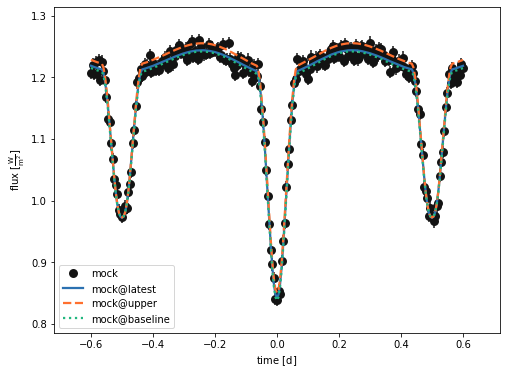

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [13]:
b.run_compute(irrad_method='none', model='baseline', overwrite=True)
b['mock'].plot(show=True, legend=True)

You guessed it: as flux scaling is prescribed by the parametrized luminosity (`pblum`), absolute temperature have little impact on a single lightcurve. It is their _ratio_ that exacts a significant influence by modifying eclipse depth ratios. Their absolute values, on the other hand, only marginally influence the light curve, mostly through limb darkening and, to an even lesser extent, through reflection (which we turned off anyway). The situation where different parameters yield indistinguishable values of the cost function is called a _degeneracy_.

Another significant degeneracy arises between stellar sizes (equivalent radii) and orbital inclination: a slightly larger star at a slightly lower inclination will have a lightcurve indistinguishable from a slightly smaller star at a slightly higher inclination. Let's take a closer look at that! First, reset parameter values:

In [14]:
b['requiv@primary'] = 1.35
b['requiv@secondary'] = 0.80
b['teff@primary'] = 6150
b['teff@secondary'] = 5680

Now we loop over nearby inclinations and adjust other relevant parameters:

In [15]:
adjusts = ['requiv@primary', 'requiv@secondary', 'pblum@primary@mock']
steps = [0.03, 0.03, 0.03]
req1s, req2s = [], []

for incl in np.linspace(81.5, 85.5, 9):
    for iter in range(1, 4):
        corrections = run_dc(adjusts, steps, deriv_method='asym')
        adopt_dc(adjusts, corrections[0])
        print(f'incl: {incl:4.1f}, corrections: {corrections[0]}, chi2: {corrections[1][0]} (it {iter})')
        if iter == 3:
            req1s.append(b['value@requiv@primary'])
            req2s.append(b['value@requiv@secondary'])

incl: 81.5, corrections: [ 0.01165716 -0.00056482  0.00023556], chi2: 203.3890132455415 (it 1)
incl: 81.5, corrections: [8.23907771e-04 8.02138554e-05 5.32044745e-04], chi2: 203.79527126258972 (it 2)
incl: 81.5, corrections: [-0.00056607 -0.00012477  0.00034002], chi2: 203.34914635956258 (it 3)
incl: 82.0, corrections: [-1.86725130e-04 -5.76679052e-05  2.70193936e-04], chi2: 203.2686470829351 (it 1)
incl: 82.0, corrections: [-3.87062007e-04 -9.94507385e-05  1.55335943e-04], chi2: 203.25500285252093 (it 2)
incl: 82.0, corrections: [0.00038881 0.00010116 0.0002368 ], chi2: 203.265156611853 (it 3)
incl: 82.5, corrections: [ 3.93071549e-05 -2.19114639e-05  2.34708192e-04], chi2: 203.25487958716576 (it 1)
incl: 82.5, corrections: [0.00077761 0.00012606 0.00043275], chi2: 203.7807211383591 (it 2)
incl: 82.5, corrections: [-0.00064055 -0.0001533   0.0002336 ], chi2: 203.29338118768266 (it 3)
incl: 83.0, corrections: [-4.06721242e-04 -8.38031310e-05  9.28302110e-05], chi2: 203.32230645767095 (

The mere fact that all these chi2 values are in the same ballpark is already alarming and it should help you appreciate that formal errors computed from the covariance matrix (which we deliberately omit from this tutorial because they are largely meaningless) are grossly underestimated. On the flip side, we will show you how to sample the parameter space heuristically and obtain more realistic error estimates. For now, let us see how the equivalent radii correlate with inclination:

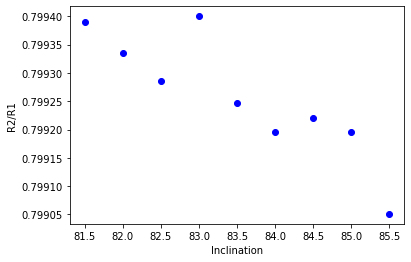

In [16]:
plt.xlabel('Inclination')
plt.ylabel('R2/R1')
plt.plot(np.linspace(81.5, 85.5, 9), req2s, 'bo')

This tutorial only scratched the surface of a very complicated issue. Chances are that, provided you stay in the field, _everything_ you do over the course of your career will be plagued by degeneracy.

### Exercises

1. Thinking about geometry and radiation, what other parameters would you expect to exhibit a large degree of correlation, and in consequence lead to degeneracy? Write them out here and justify your reasoning.

2. Explore the correlation between equivalent radii, and the correlation between the mass ratio and secondary star's equivalent radius.